# Ejemplo de uso de Embeddings

La intención de este notebook es realizar un ejemplo que no sea NLP utilizando Embeddings con Keras

## Importamos librerias

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

## Creamos una serie temporal Fake

La idea del ejercicio será comparar el uso de valores categóricos "simples" <br>y ver cuánto mejoran con embeddings (o no)

In [76]:
ventas_falsas=pd.DataFrame()

anio=[]
mes=[]
dias=[]
vtas=[]
clientes=[]
cliente=1000
for a in range(1,5):
    for m in range(1,13):
        for i in range(0,30):
            anio.append(a)
            mes.append(m)
            dias.append(i%7)
            cliente = (cliente/3) + (i+1+(m*2)+(a*2))
            clientes.append(cliente)
            if i==0:
                vtas.append(0.0) # los domingos esta cerrado
            else:
                if m<4:
                    dinero = ((i%7) * cliente * 5)
                if m<8:
                    dinero = ((i%7) * cliente * 15)
                else:
                    dinero = ((i%7) * cliente * 25)
                if(i==5):
                    dinero = dinero*1.25 #los viernes vende mas
                if(i==3):
                    dinero = dinero*0.75 #los miercoles vende menos
                vtas.append(dinero)

ventas_falsas['anio']=anio
ventas_falsas['mes']=mes
ventas_falsas['dia']=dias
ventas_falsas['clientes']=clientes
ventas_falsas['ventas']=vtas

ventas_falsas.head()

,anio,mes,dia,clientes,ventas
0,1,1,0,338.333333,0.000000
1,1,1,1,118.777778,1781.666667
2,1,1,2,46.592593,1397.777778
3,1,1,3,23.530864,794.166667
4,1,1,4,16.843621,1010.617284


In [77]:
# Normalize time series data
# prepare data for normalization
values = ventas_falsas['ventas'].values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])


Min: 0.000000, Max: 13387.500000
[0.]
[0.13308434]
[0.10440917]
[0.05932151]
[0.07548962]
[0.]
[1781.66666667]
[1397.77777778]
[794.16666667]
[1010.61728395]


In [78]:
values2 = ventas_falsas['clientes'].values
values2 = values2.reshape((len(values), 1))
# train the normalization
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(values2)
print('Min: %f, Max: %f' % (scaler2.data_min_, scaler2.data_max_))
# normalize the dataset and print the first 5 rows
normalized2 = scaler2.transform(values2)

ventas_falsas['clientes']=normalized2
ventas_falsas['ventas']=normalized

training_data=ventas_falsas.drop(['ventas'],1)
target_data=ventas_falsas['ventas']

ventas_falsas.head()

Min: 14.305556, Max: 338.333333


,anio,mes,dia,clientes,ventas
0,1,1,0,1.000000,0.000000
1,1,1,1,0.322417,0.133084
2,1,1,2,0.099643,0.104409
3,1,1,3,0.028471,0.059322
4,1,1,4,0.007833,0.075490


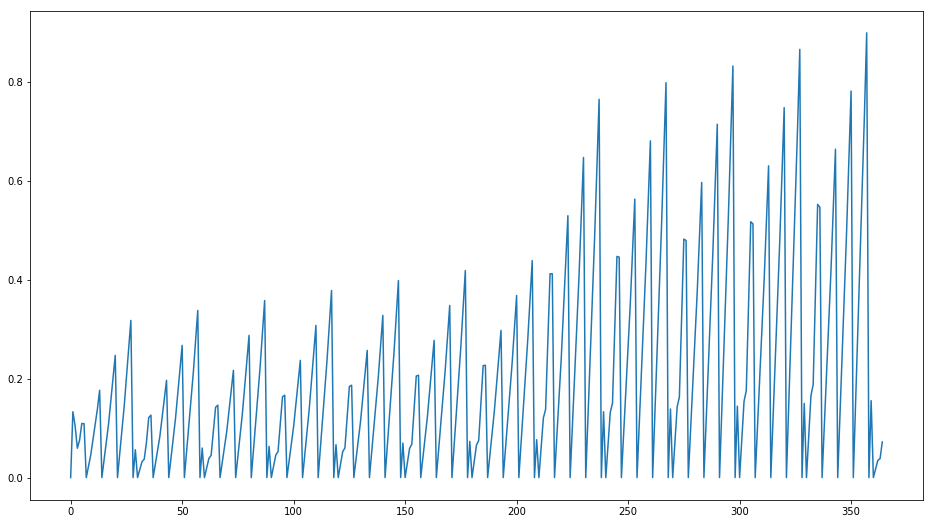

In [79]:
ventas_falsas['ventas'][0:365].plot() # Visualizamos el 1er anio
#ventas_falsas['ventas'][366:365*2].plot()
#ventas_falsas['ventas'][366+366:365*3].plot()

Lo que queremos ver, es la predicción con una red neuronal normal usando semana como categ.<br>
y ver con otra red pero con Embeddings, si mejora.

## Parametros

In [80]:
#Configuraciones generales
EPOCHS=50
dense_n = 20
cuantos=250 #para graficar
fun_act='sigmoid' #Probado también con tanh relu

## Subdividimos el Set en entrenamiento y Validación

In [81]:
training_data.shape

(1440, 4)

In [82]:
valid_data = training_data[1000:1440]
valid_target=target_data[1000:1440]
valid_target.shape

(440,)

In [83]:
training_data = training_data[0:1000]
target_data=target_data[0:1000]
target_data.shape

(1000,)

# 1 -Red Neuronal - Sin Embeddings

Creamos una red neuronal de una capa para predecir precios

In [84]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model0.summary()

history=model0.fit(training_data, target_data, epochs=EPOCHS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 21        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2036 - mean_squared_error: 0.2036
Epoch 2/50
1000/1000 [==============================] - 0s 120us/step - loss: 0.1080 - mean_squared_error: 0.1080
Epoch 3/50
1000/1000 [==============================] - 0s 116us/step - loss: 0.0628 - mean_squared_error: 0.0628
Epoch 4/50
1000/1000 [==============================] - 0s 101us/step - loss: 0.0459 - mean_squared_error: 0.0459
Epoch 5/50
1000/1000 [==============================] - 0s 92us/step - loss: 0.0397 - 

In [85]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

1000/1000 [==============================] - 1s 529us/step

mean_squared_error: 0.0082
440/440 [==============================] - 0s 57us/step

mean_squared_error: 0.0206


440


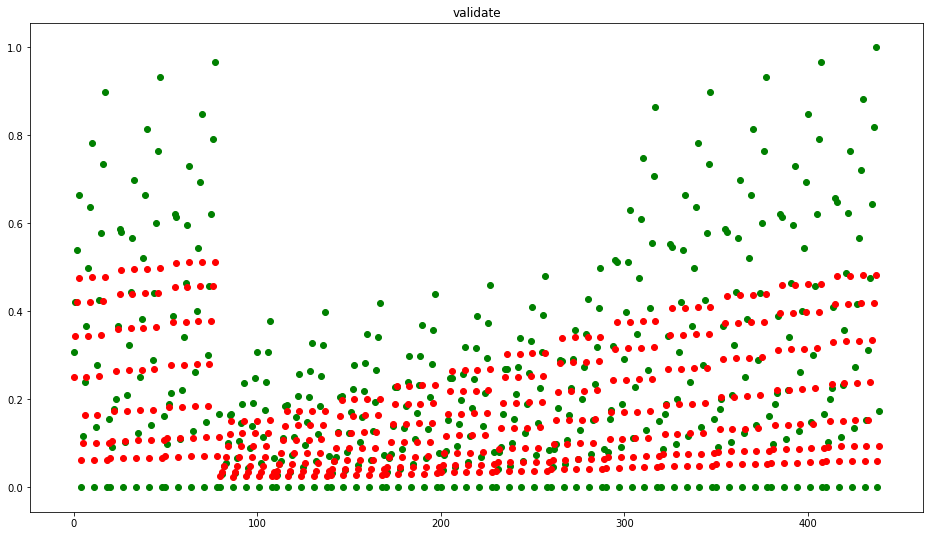

In [86]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

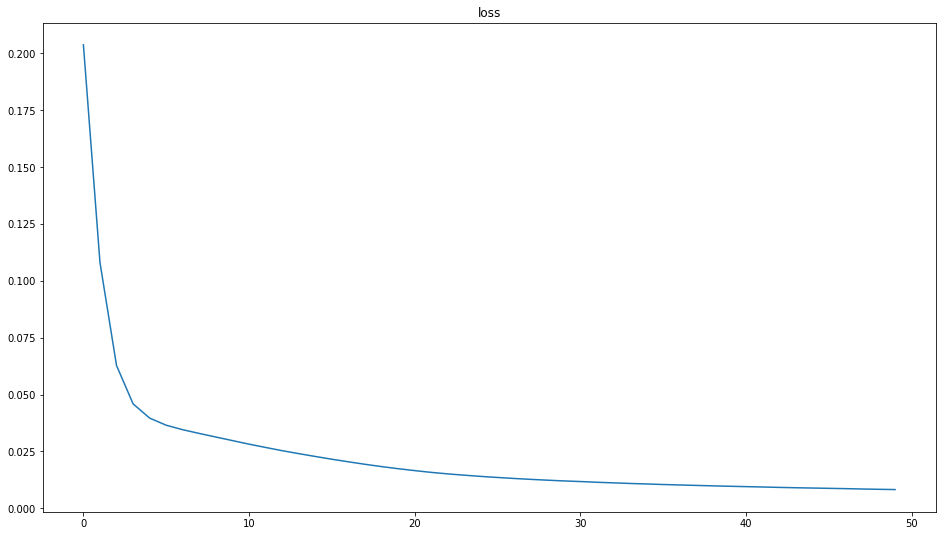

In [87]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 2 - Red Neuronal - con Embeddings

In [88]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)
outp = Dense(1,activation=fun_act)(x)
model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model.summary()

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
anios (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 30)        210         dias[0][0]                       
__________________________________________________________________________________________________
embedding_

1000/1000 [==============================] - 0s 139us/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/50
1000/1000 [==============================] - 0s 143us/step - loss: 0.0038 - mean_squared_error: 0.0038


In [89]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))


1000/1000 [==============================] - 1s 846us/step

mean_squared_error: 0.0037
440/440 [==============================] - 0s 84us/step

mean_squared_error: 0.0049


440


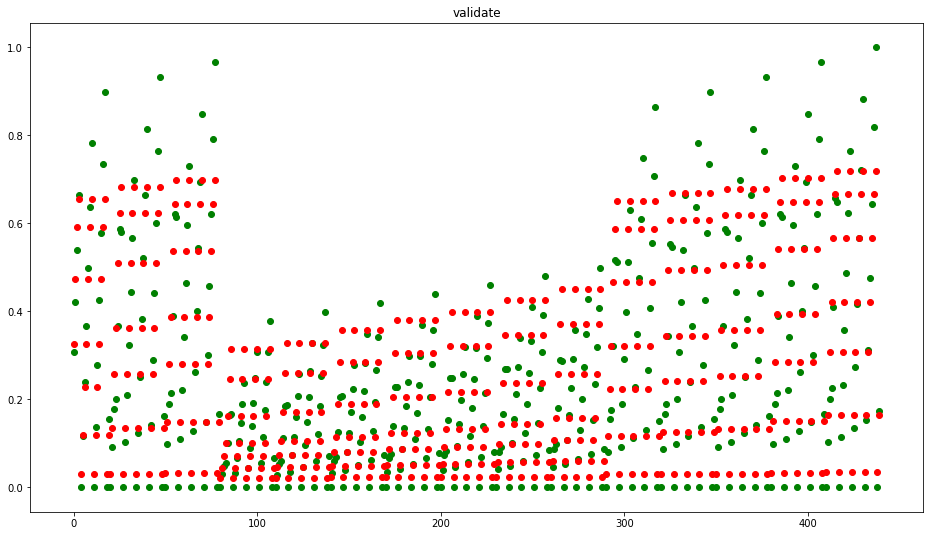

In [90]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

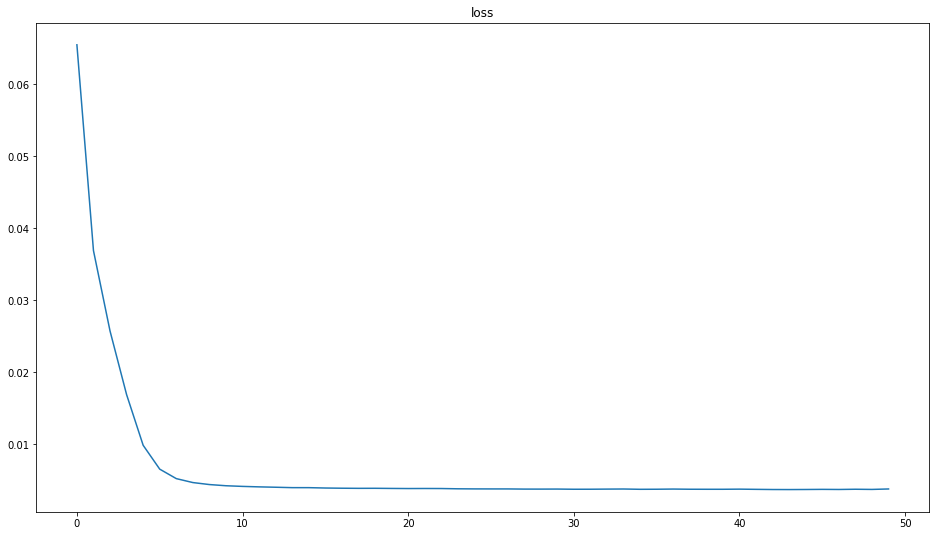

In [91]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos Visualmente

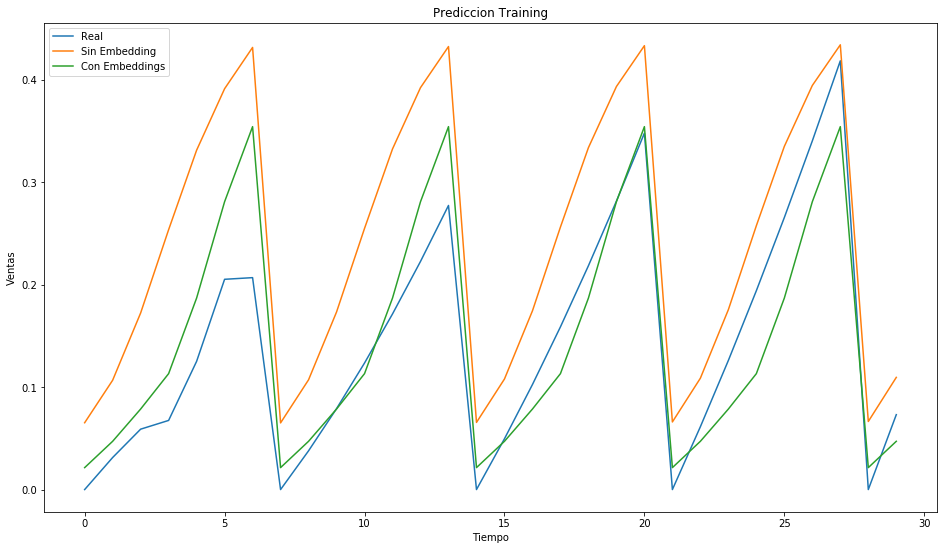

In [92]:
pred0 = model0.predict([training_data])
pred1 = model.predict([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']])

cuantos=30
offset=150
predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(target_data[i+offset])
    
Nc = range(0, cuantos)

plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))
#plt.legend(loc='upper left')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Training')
plt.show()

Pareciera que la curva de red con Embeddings se aproxima un poco más a la curva real

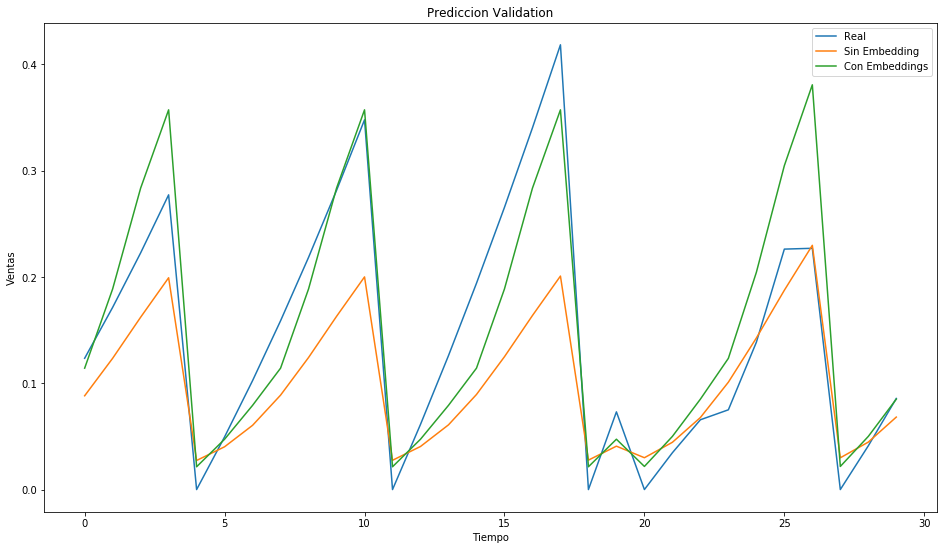

In [93]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 3 - Red Neuronal con más capas Sin Embeddings

In [94]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(dense_n, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

history=model0.fit(training_data, target_data, epochs=EPOCHS)

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 2/50
1000/1000 [==============================] - 0s 96us/step - loss: 0.0364 - mean_squared_error: 0.0364
Epoch 3/50
1000/1000 [==============================] - 0s 80us/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 4/50
1000/1000 [==============================] - 0s 87us/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 5/50
1000/1000 [==============================] - 0s 148us/step - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 6/50
1000/1000 [==============================] - 0s 129us/step - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 7/50
1000/1000 [==============================] - 0s 129us/step - loss: 0.0234 - mean_squared_error: 0.0234
Epoch 8/50
1000/1000 [==============================] - 0s 122us/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 9/50
1000/1000 [==============================] - 0s 121us/step - loss: 0.0177 - mean_s

In [95]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

1000/1000 [==============================] - 1s 600us/step

mean_squared_error: 0.0041
440/440 [==============================] - 0s 63us/step

mean_squared_error: 0.0051


440


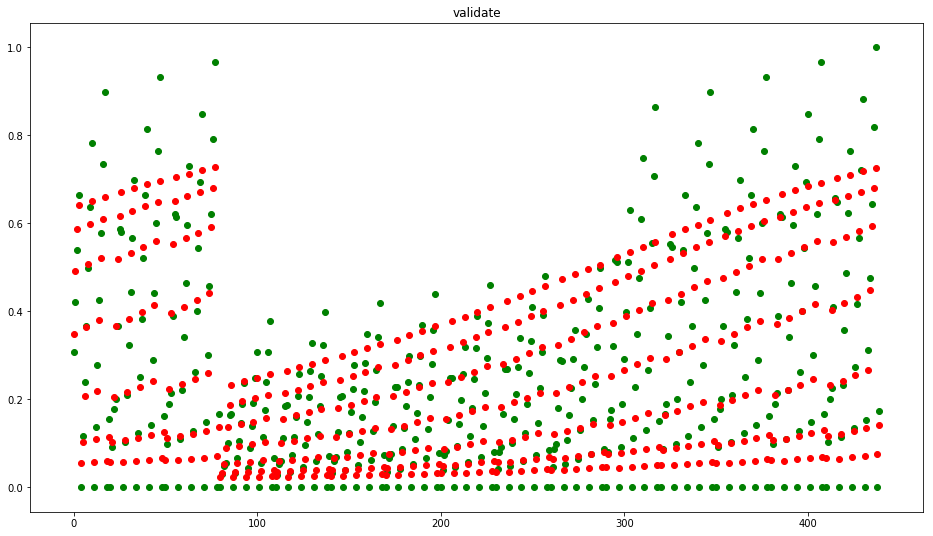

In [96]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

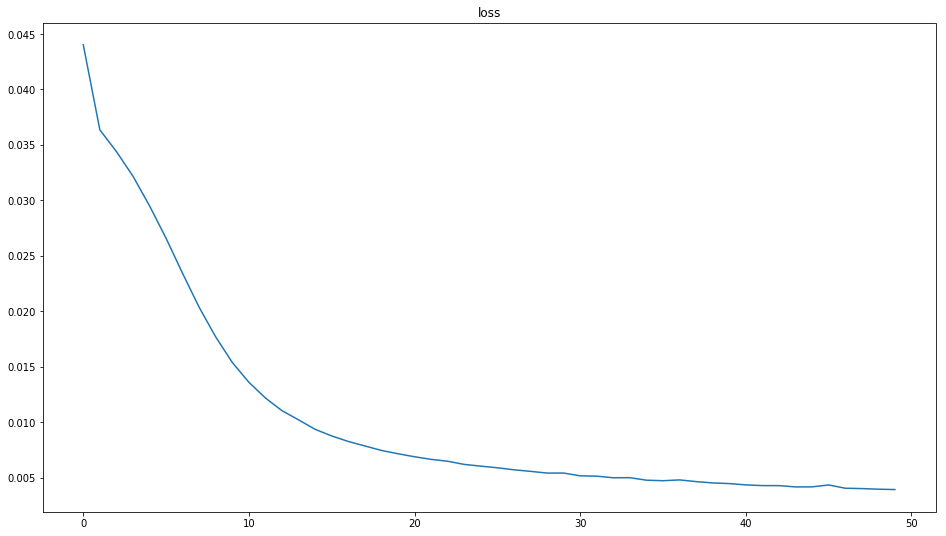

In [97]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 4 - Red Neuronal con Embedings y 2 capas

In [98]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)

x2 = Dense(dense_n,activation=fun_act)(x)

outp = Dense(1,activation=fun_act)(x2)
model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0678 - mean_squared_error: 0.0678
Epoch 2/50
1000/1000 [==============================] - 0s 167us/step - loss: 0.0382 - mean_squared_error: 0.0382
Epoch 3/50
1000/1000 [==============================] - 0s 151us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 4/50
1000/1000 [==============================] - 0s 144us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 5/50
1000/1000 [==============================] - 0s 147us/step - loss: 0.0265 - mean_squared_error: 0.0265
Epoch 6/50
1000/1000 [==============================] - 0s 145us/step - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 7/50
1000/1000 [==============================] - 0s 130us/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 8/50
1000/1000 [==============================] - 0s 101us/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 9/50
1000/1000 [==============================] - 0s 130us/step - loss: 0.0076 - mea

In [99]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

1000/1000 [==============================] - 1s 934us/step

mean_squared_error: 0.0037
440/440 [==============================] - 0s 72us/step

mean_squared_error: 0.0050


440


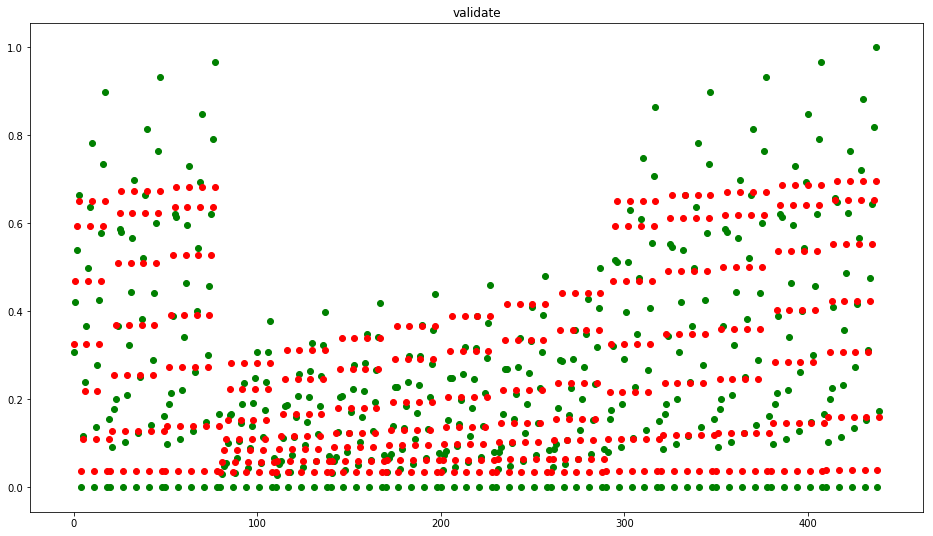

In [100]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

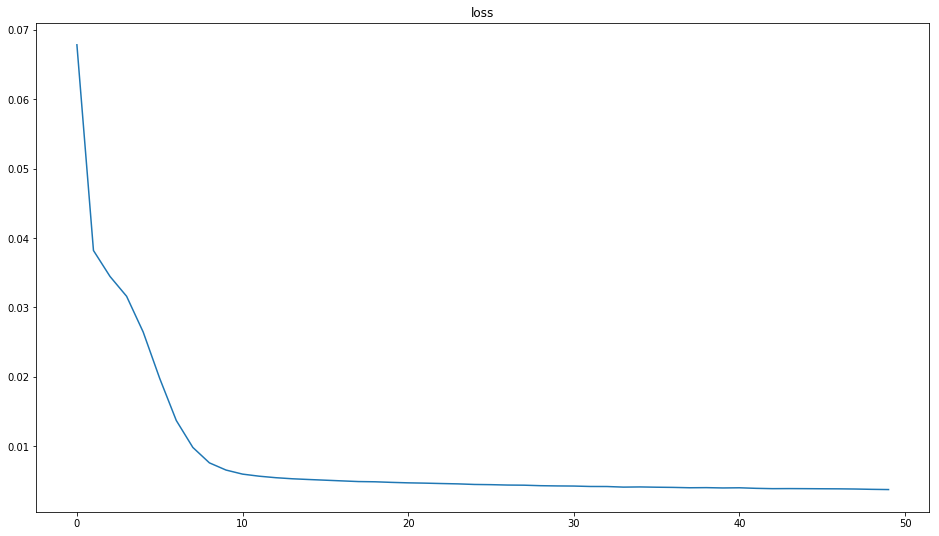

In [101]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos RRNN con 2 capas y RRNN con Embedings 2 capas

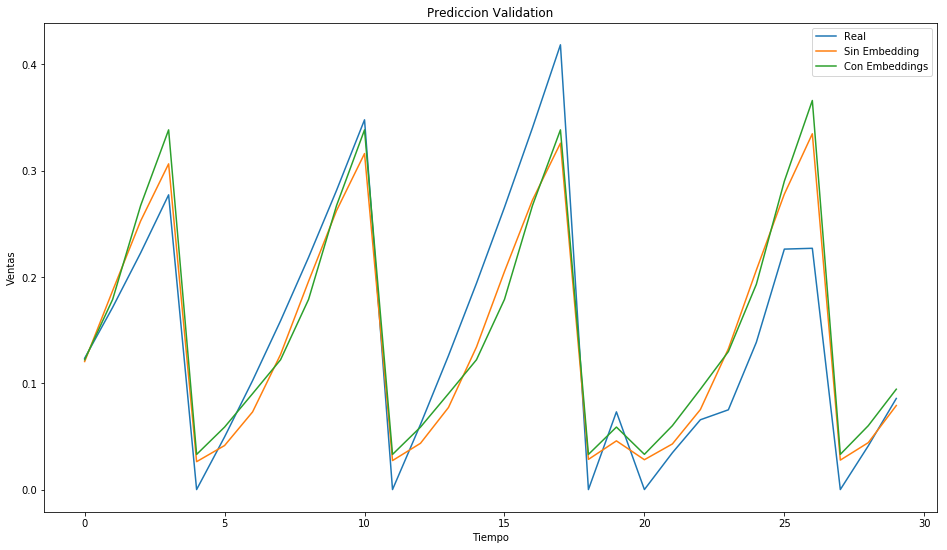

In [102]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 5 - LSTM con Embeddings

In [103]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

x = concatenate([(emb_dias), (emb_meses),(emb_anios)])

#x = Flatten()(fe)

x = LSTM(units = 25, return_sequences = True, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)
x = LSTM(units = 25, return_sequences = False, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)

x = Dense(dense_n,activation='relu')(x)
x = Dropout(0.2)(x)

outp = Dense(1,activation='sigmoid')(x)

#outp = Dense(1,activation=fun_act)(x)
model3 = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model3.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model3.summary()

history=model3.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
anios (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 1, 30)        210         dias[0][0]                       
__________________________________________________________________________________________________
embedding_

1000/1000 [==============================] - 0s 335us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 43/50
1000/1000 [==============================] - 0s 383us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 44/50
1000/1000 [==============================] - 0s 374us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 45/50
1000/1000 [==============================] - 0s 342us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 46/50
1000/1000 [==============================] - 0s 324us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 47/50
1000/1000 [==============================] - 0s 250us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 48/50
1000/1000 [==============================] - 0s 232us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 49/50
1000/1000 [==============================] - 0s 377us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 50/50
1000/1000 [==============================] - 0s 472us/step - loss: 0.0049 - mean

In [104]:
# evaluamos el modelo
scores = model3.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

scores = model3.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

1000/1000 [==============================] - 1s 1ms/step

mean_squared_error: 0.0035
440/440 [==============================] - 0s 93us/step

mean_squared_error: 0.0046


440


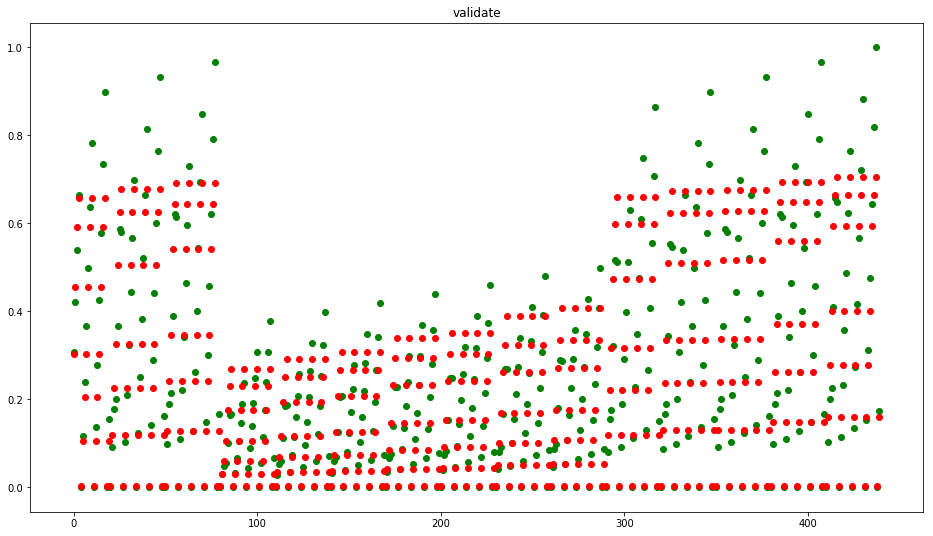

In [105]:
results=model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

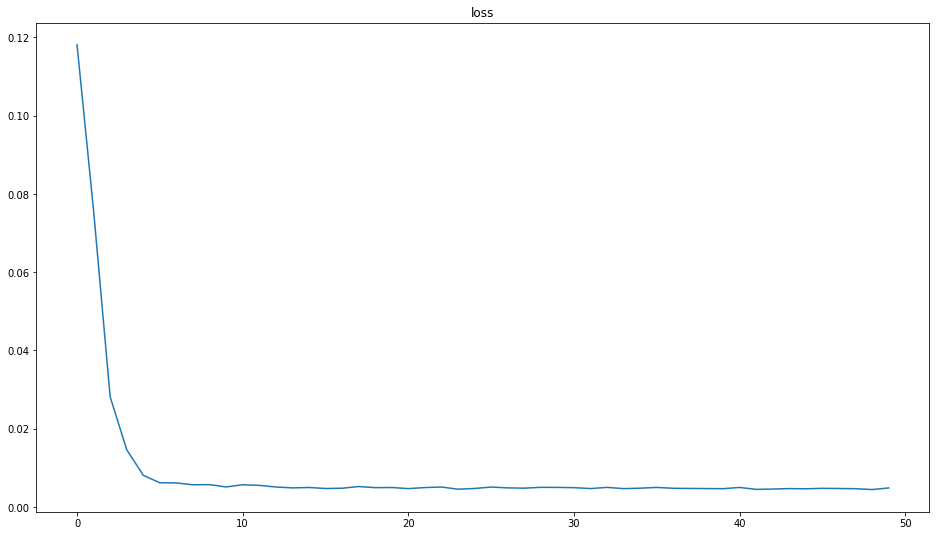

In [106]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos la NN sin EMbedding con la LSTM con Embeddings

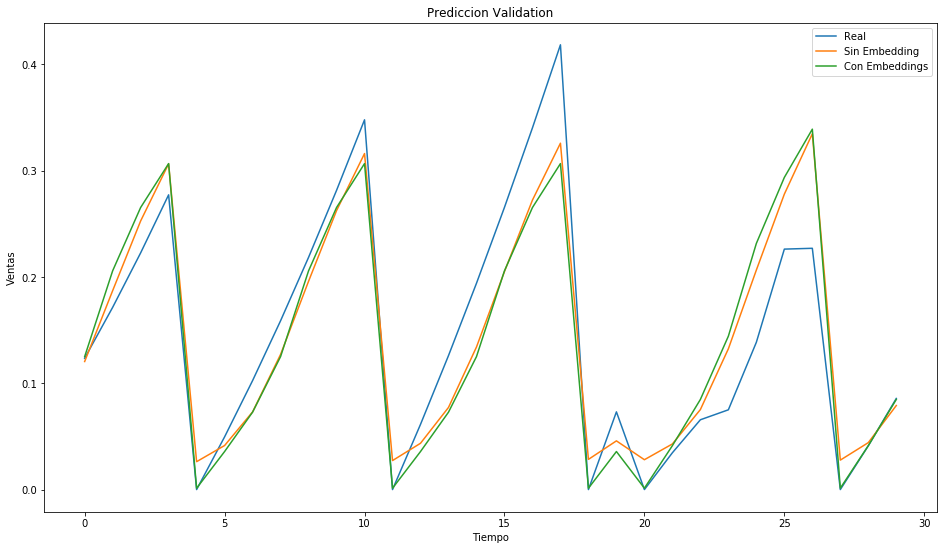

In [107]:
pred0 = model0.predict([valid_data])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# Comparamos la red con Embeddings y la LSTM con Embeddings

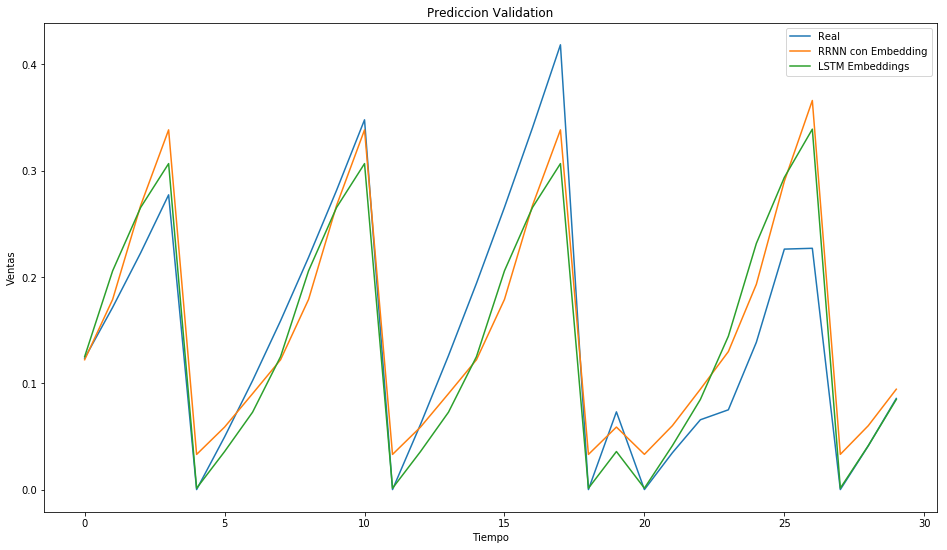

In [108]:
pred0 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','RRNN con Embedding','LSTM Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

Esta última está muy parejo!

# Conclusión

Debo decir que si bien se nota una mejora con el uso de Embeddings, al menos para este ejemplo inventado <br>
no parece haber tanta diferencia con el uso de redes neuronales "normales" (MLP) y valores categóricos.<br>

Creo que sería conveniente Realizar más pruebas en diversos set de datos.